# ***PROJEKT - ANALÝZA JUST EAT CYCLES***

Cieľom projektu je analyzovať dáta o požičiavaní bicyklov prevádzkovateľa Just Eat Cycles s cieľom systém zefektívniť. Jedná se o projekt požičiavania bicyklov v Edinburghu, kde si človek môže nejaký bicykel požičiať a potom ho vrátiť v nejakej ďalšej stanici. Problém je, že v niektorých staniciach se bicykle pravidelne hromadia a inde naopak chýbajú. Analýzu budem robiť v týchto krokoch:

- vykonám štandardnú deskriptívnu štatistiku dát
- identifikujem aktívne a neaktívne stanice
- identifikujem nejfrekventovanějšie stanice
- identifikujem stanice, na ktorých se bicykle hromadia a stanice, kde potenciálne chýbajú
- spočítam vzdialenosti mezi jednotlivými stanicami
- ako dlho trvá jedna výpožička? Nájdem odľahlé hodnoty, zobrazím histogram
- zobrazím vývoj dopytu po požičiavaní bicyklov v čase
- identifikujem příčiny výkyvu dopytu
- zistím vplyv počasia na dopyt po bicykloch
- vplyv víkendu na požičiavanie bicyklov


# **Inštalovanie knihovien a načítanie dát**

In [2]:
import numpy as np
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt

Cieľový súbor je uložený v databázi, do jej prístupu využijem knihovnu Sqlalchemy a tabuľku zobrazím SQL dotazom. 

In [3]:
!pip install pymysql

student_conn_string = "mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
engeto_data_conn = sqlalchemy.create_engine(student_conn_string)

query = "select * from edinburgh_bikes"
bikes = pd.read_sql(query, engeto_data_conn)

In [4]:
bikes.head()

,index,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,0,2018-09-15 08:52:05,2018-09-15 09:11:48,1182,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,1,2018-09-15 09:24:33,2018-09-15 09:41:09,995,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2,2018-09-15 09:48:54,2018-09-15 10:46:40,3466,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116
3,3,2018-09-16 12:01:36,2018-09-16 12:25:26,1430,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385
4,4,2018-09-16 12:03:43,2018-09-16 12:11:16,452,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646


# **Základná deskriptívna štatistika**

Najskôr si zistím základné údaje o tabuľke. 

In [5]:
bikes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340986 entries, 0 to 340985
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   index                      340986 non-null  int64         
 1   started_at                 340986 non-null  datetime64[ns]
 2   ended_at                   340986 non-null  datetime64[ns]
 3   duration                   340986 non-null  int64         
 4   start_station_id           340986 non-null  int64         
 5   start_station_name         340986 non-null  object        
 6   start_station_description  338612 non-null  object        
 7   start_station_latitude     340986 non-null  float64       
 8   start_station_longitude    340986 non-null  float64       
 9   end_station_id             340986 non-null  int64         
 10  end_station_name           340986 non-null  object        
 11  end_station_description    338426 non-null  object  

Datové typy odpovedajú hodnotám v jednotlivých stĺpcoch. NULL hodnoty se nachádzajú len v stĺpcoch start_station_description a end_station_description. Vzhľadom k tomu, že tieto hodnoty využívať nepotrebujem, stĺpce vymažem. 

In [6]:
bikes.drop(columns=['start_station_description','end_station_description'], inplace=True)
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340986 entries, 0 to 340985
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   index                    340986 non-null  int64         
 1   started_at               340986 non-null  datetime64[ns]
 2   ended_at                 340986 non-null  datetime64[ns]
 3   duration                 340986 non-null  int64         
 4   start_station_id         340986 non-null  int64         
 5   start_station_name       340986 non-null  object        
 6   start_station_latitude   340986 non-null  float64       
 7   start_station_longitude  340986 non-null  float64       
 8   end_station_id           340986 non-null  int64         
 9   end_station_name         340986 non-null  object        
 10  end_station_latitude     340986 non-null  float64       
 11  end_station_longitude    340986 non-null  float64       
dtypes: datetime64[ns

Príkazom describe si zobrazím deskriptívnu štatistiku dát. Keďže výstupné hodnoty nemali požadovaný tvar (napr.	3.409860e+05), upravila som ich formát na 2 desatinné miesta.

In [7]:
pd.options.display.float_format = "{:.2f}".format
bikes.describe()

,index,duration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude
count,340986.00,340986.00,340986.00,340986.00,340986.00,340986.00,340986.00,340986.00
mean,9383.82,2061.25,873.60,55.95,-3.20,912.86,55.95,-3.20
std,7516.83,8703.69,657.83,0.01,0.04,664.57,0.02,0.04
min,0.00,61.00,171.00,55.91,-3.41,171.00,53.40,-3.41
25%,3320.00,620.00,259.00,55.94,-3.21,262.00,55.94,-3.21
50%,7433.00,1147.00,862.00,55.95,-3.19,880.00,55.95,-3.19
75%,13523.00,2512.00,1728.00,55.96,-3.18,1728.00,55.96,-3.18
max,29550.00,1373043.00,2268.00,55.99,-3.06,2268.00,55.99,-2.99


# **Aktívne a neaktívne stanice**

Na určenie aktívnych a neaktívnych staníc si vytvorím prehľad staníc s údajmi, koľko bicyklov bolo požičaných a vrátených v jednotlivých staniciach za rok 2020. Vychádzam z predpokladu, že je možné, že niektoré stanice mohli byť v priebehu času zrušené. 

V prvom kroku si zjednotením start_station_id a end_station_id do jedného setu a zistím, koľko staníc bolo historicky používaných.

In [8]:
all_station = set(bikes['start_station_id']).union(set(bikes['end_station_id']))
len(all_station)

200

V ďalšom kroku si vyfiltrujem sledované obdobie a vytvorím tabuľky, ktoré budú sumarizovať:
1.   počet výpožičiek a
2.   vrátení bicyklov
v jednotlivých staniciach. 

Tabuľky nakoniec spojím do jednej.

In [9]:
df_lately=bikes[bikes['started_at']>'8/1/2020'].copy()

df_s=df_lately[['start_station_id','duration']].groupby('start_station_id').count().reset_index()
df_s =df_s.rename(columns={'start_station_id':'station_id', 'duration':'borrowed'})

df_e=df_lately[['end_station_id','duration']].groupby('end_station_id').count().reset_index()
df_e =df_e.rename(columns={'end_station_id':'station_id', 'duration':'returned'})

a_station = df_s.merge(df_e, how='outer',on='station_id')
a_station['total']=a_station['borrowed']+a_station['returned']
a_station.sort_values(by='total',ascending=False)

,station_id,borrowed,returned,total
52,1728,2448,3142,5590
19,265,2720,2367,5087
94,1824,1578,2606,4184
24,358,1711,2279,3990
27,1024,2065,1617,3682
...,...,...,...,...
97,1864,61,42,103
95,1859,46,44,90
104,1874,45,45,90
103,1871,13,17,30


Predpoklad sa naplnil, v datasetu máme 200 staníc a v roku 2020 bolo aktívnych (t.j. aspoň 1 záznam o požíčaní alebo vrátení) len 119 staníc. Zmenou dátumu na jednotlivé mesiace roku 2020 som zistila, že za posledný pol rok (t.j. od 5/2020) bolo aktívnych 111 staníc, od 8/2020 to bolo o jednu menej, 110. Záver teda je, že ku koncu októbra 2020 bolo aktívnych 110 staníc a 90 staníc bolo neaktívnych.

In [10]:
active= set(a_station['station_id'])
unactive=all_station.symmetric_difference(active)
unactive=pd.DataFrame(unactive).rename(columns={0:'station_id'})
unactive

,station_id
0,1026
1,1027
2,1030
3,1032
4,1033
...,...
85,980
86,981
87,982
88,991


# **Nejfrekventovanejšie stanice**

K určeniu najfrekventovanejších staníc budem vychádzať z podobnej tabuľky ako v predošlom zadaní, len obdobie zvolím posledný rok. Niektoré stanice majú v stĺpcoch Borrowed a Returned NULL hodnoty, vyriešim to nahradením nulou.

In [11]:
df=bikes[bikes['started_at']>'10/31/2019']

df_b=df[['start_station_id','duration']].groupby('start_station_id').count().reset_index()
df_b =df_b.rename(columns={'start_station_id':'station_id', 'duration':'borrowed'})

df_r=df[['end_station_id','duration']].groupby('end_station_id').count().reset_index()
df_r =df_r.rename(columns={'end_station_id':'station_id', 'duration':'returned'})

station = df_b.merge(df_r, how='outer',on='station_id')
station.fillna(0,inplace=True)
station['total']=station['borrowed']+station['returned']
station=station.sort_values(by='total',ascending=False).set_index('station_id')
station

,borrowed,returned,total
station_id,,,
1728,8007.00,10041.00,18048.00
265,7683.00,6737.00,14420.00
1824,5617.00,7961.00,13578.00
250,5088.00,6906.00,11994.00
1024,6398.00,5184.00,11582.00
...,...,...,...
1033,5.00,6.00,11.00
889,6.00,4.00,10.00
299,0.00,4.00,4.00


Zobrazím si histogram vyťaženosti staníc.

---



Text(0.5, 1.0, 'Station occupancy')

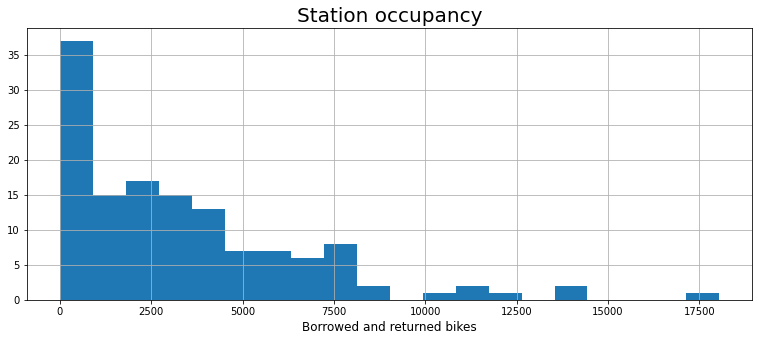

In [14]:
fig, ax = plt.subplots(figsize=(13,5))
station['total'].hist(bins=20)
ax.set_xlabel('Borrowed and returned bikes', fontsize=12)
ax.set_title('Station occupancy', fontsize=20)

Za najfrekventovanejšie budem pokladať stanice, kde súhrn vrátených a požičaných bicyklov je väčší než 10 000.

In [15]:
most_freq = station[station['total']>10000]
most_freq

,borrowed,returned,total
station_id,,,
1728,8007.00,10041.00,18048.00
265,7683.00,6737.00,14420.00
1824,5617.00,7961.00,13578.00
250,5088.00,6906.00,11994.00
1024,6398.00,5184.00,11582.00
358,4876.00,6488.00,11364.00
1722,4859.00,5600.00,10459.00


# **Stanice s nedostatkem alebo nadbytkom bicyklov**

Budem vychádzať z tabuľky **station**, ktorú som si vytvorila v predošlom zadaní. Vytvorím si nový stĺpec vyjadrujúci rozdiel medzi vypožičanými a vrátenými bicyklami v jednotlivých staniciach za posledný rok.

In [16]:
station2=station.copy()
station2['difference']=station2['returned'] - station2['borrowed']
station2.sort_values(by='difference',ascending=False)

,borrowed,returned,total,difference
station_id,,,,
1824,5617.00,7961.00,13578.00,2344.00
1728,8007.00,10041.00,18048.00,2034.00
250,5088.00,6906.00,11994.00,1818.00
358,4876.00,6488.00,11364.00,1612.00
285,3192.00,4264.00,7456.00,1072.00
...,...,...,...,...
189,2079.00,773.00,2852.00,-1306.00
259,4929.00,3487.00,8416.00,-1442.00
247,3578.00,2101.00,5679.00,-1477.00


Zobrazím si histogram, aby som prehľadnejšie dokázala posúdiť nerovnováhu v staniciach. Vidíme, že vo väčšine staníc je stav relatívne vyvážený, ale existujú taktiež stanice s výrazným nedostatkom alebo prebytkom bicyklov. Je zjavné, že niektoré stanice sa viac využívajú na požičanie bicyklov a niektoré zas viac na ich vrátenie.

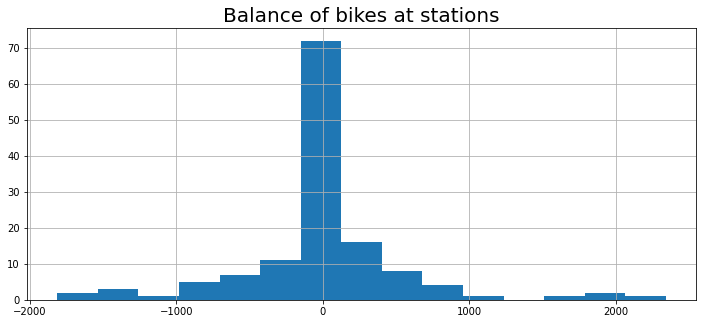

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
station2['difference'].hist(bins=15)
plt.title('Balance of bikes at stations', fontsize=20)
plt.show()

Zobrazím si stanice s výraznejším nedostatkom bicyklov:

In [18]:
lack_station = station2[station2['difference']<-700]
lack_station.sort_values(by='difference')

,borrowed,returned,total,difference
station_id,,,,
248,4191.00,2377.00,6568.00,-1814.00
1767,4571.00,2966.00,7537.00,-1605.00
247,3578.00,2101.00,5679.00,-1477.00
259,4929.00,3487.00,8416.00,-1442.00
189,2079.00,773.00,2852.00,-1306.00
1024,6398.00,5184.00,11582.00,-1214.00
260,2477.00,1529.00,4006.00,-948.00
265,7683.00,6737.00,14420.00,-946.00
264,3399.00,2479.00,5878.00,-920.00


A stanice s prebytkom bicyklov:

In [19]:
surplus_station = station2[station2['difference']>700]
surplus_station.sort_values(by='difference', ascending=0)

,borrowed,returned,total,difference
station_id,,,,
1824,5617.00,7961.00,13578.00,2344.00
1728,8007.00,10041.00,18048.00,2034.00
250,5088.00,6906.00,11994.00,1818.00
358,4876.00,6488.00,11364.00,1612.00
285,3192.00,4264.00,7456.00,1072.00
1818,2884.00,3713.00,6597.00,829.00
258,2932.00,3699.00,6631.00,767.00
1722,4859.00,5600.00,10459.00,741.00
1800,3061.00,3776.00,6837.00,715.00


Odporúčala by som spoločnosti zamyslieť sa nad tým, či by nebolo vhodné pravidelne odvážať bicykle zo staníc s prebytkom bicyklov do staníc s ich nedostatkom.

# **Vzdialenosti mezi jednotlivými stanicami**

Najskôr si vytvorím tabuľku s údajmi o začiatočnej a konečnej stanici a ich súradniciach. Na výpočet vzdialenosti medzi stanicami použijem Haversine vzorec.

In [20]:
dfd = bikes[['start_station_id','end_station_id','start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']]
dfd

,start_station_id,end_station_id,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,247,259,55.95,-3.21,55.95,-3.19
1,259,262,55.95,-3.19,55.96,-3.20
2,262,250,55.96,-3.20,55.98,-3.17
3,255,254,55.92,-3.18,55.92,-3.18
4,255,253,55.92,-3.18,55.92,-3.17
...,...,...,...,...,...,...
340981,1051,1051,55.94,-3.20,55.94,-3.20
340982,1798,1814,55.95,-3.19,55.96,-3.17
340983,1028,1019,55.95,-3.19,55.95,-3.20
340984,358,259,55.97,-3.18,55.95,-3.19


In [21]:
def haversine_np(lon1, lat1, lon2, lat2):
  
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

dfd['distance']=haversine_np(dfd['start_station_longitude'],dfd['start_station_latitude'],dfd['end_station_longitude'],dfd['end_station_latitude'])
dfd.sort_values(by='distance')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,start_station_id,end_station_id,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,distance
170492,1763,1763,55.96,-3.22,55.96,-3.22,0.00
54138,246,246,55.94,-3.17,55.94,-3.17,0.00
54139,246,246,55.94,-3.17,55.94,-3.17,0.00
54140,259,259,55.95,-3.19,55.95,-3.19,0.00
54141,259,259,55.95,-3.19,55.95,-3.19,0.00
...,...,...,...,...,...,...,...
306584,1864,1728,55.98,-3.38,55.96,-3.12,16.59
197404,1865,1800,55.99,-3.38,55.95,-3.09,18.38
27184,189,280,55.95,-3.19,53.40,-2.99,284.17
27010,349,280,55.96,-3.22,53.40,-2.99,284.83


Najväčšia vzdialenosť medzi stanicami bola 285 km, čo v rámci jedného mesta nie je možné, preto sa pozriem detailne na záznamy pre konečnú stanicu 280.

In [22]:
bikes[bikes['end_station_id'] ==280]

,index,started_at,ended_at,duration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude
27010,4304,2019-03-22 12:15:48,2019-03-22 13:24:21,4112,349,Orchard Brae House,55.96,-3.22,280,Smarter Travel Station,53.40,-2.99
27013,4307,2019-03-22 12:44:51,2019-03-23 07:41:04,68173,357,Macdonald Road,55.96,-3.19,280,Smarter Travel Station,53.40,-2.99
27184,4478,2019-03-23 13:20:22,2019-03-23 14:19:19,3536,189,City Chambers,55.95,-3.19,280,Smarter Travel Station,53.40,-2.99


Na základe súradníc by sa malo jednať o mesto Liverpool, ale keďže doba vypožičania je vo 2 prípadoch menšia ako 1hod 15min, nie je reálne za daný čas prekonať vzdialenosť 285 km a preto tieto hodnoty budem chápať ako chybu. 

In [23]:
df_distance = dfd[dfd['distance']<284]
df_distance.describe(percentiles=[.10,.25, .5, .75, .9])

,start_station_id,end_station_id,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,distance
count,340983.00,340983.00,340983.00,340983.00,340983.00,340983.00,340983.00
mean,873.61,912.87,55.95,-3.20,55.95,-3.20,1.90
std,657.83,664.57,0.01,0.04,0.01,0.04,1.70
min,171.00,171.00,55.91,-3.41,55.91,-3.41,0.00
10%,248.00,249.00,55.94,-3.23,55.94,-3.23,0.00
25%,259.00,262.00,55.94,-3.21,55.94,-3.21,0.78
50%,862.00,880.00,55.95,-3.19,55.95,-3.19,1.54
75%,1728.00,1728.00,55.96,-3.18,55.96,-3.18,2.54
90%,1770.00,1800.00,55.97,-3.17,55.98,-3.17,4.07
max,2268.00,2268.00,55.99,-3.06,55.99,-3.06,18.38


Údaje naznačujú, že ľudia s najväčšou pravdepodobnosťou využívajú bicykle hlavne na prekonanie krátkych vzdialeností. V 90% prípadoch sa jedná o výlety do 4 km, 50% výlety do 1,5km. Okolo 10% bicyklov je vrátených v rovnakej stanici ako boli požičané. Najväčšia vzdialenosť medzi štartovnou a konečnou zastávkou bola 18,38 km.

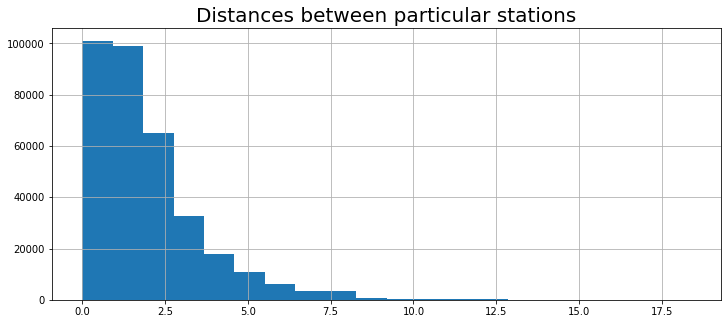

In [27]:
fig, ax = plt.subplots(figsize=(12,5))
df_distance['distance'].hist(bins=20)
plt.title('Distances between particular stations', fontsize=20)
plt.show()

# **Ako dlho trvá výpožička?**



Najskôr si vypočítam trvanie jednotlivých výpožičiek pre prípad, že by údaje v stĺpci duration obsahovali chybu.

In [28]:
from datetime import timedelta
df2 = bikes.loc[:,('started_at', 'ended_at', 'start_station_name','end_station_name')]
df2['duration_in_min']= (df2['ended_at']-df2['started_at'])/timedelta(minutes=1)
df2.sort_values(by='duration_in_min', ascending=0).head()


,started_at,ended_at,start_station_name,end_station_name,duration_in_min
137144,2020-01-10 17:45:45,2020-01-26 15:09:48,Crichton Street,Warrender Park Road,22884.05
137973,2020-01-14 07:58:47,2020-01-29 18:29:00,Corstorphine Road,Bristo Square,22230.22
136551,2020-01-08 14:00:39,2020-01-23 14:29:08,Marchmont Crescent,Castle Street,21628.48
127456,2019-12-01 11:18:47,2019-12-15 02:45:58,Murrayfield,Edinburgh Zoo,19647.18
138878,2020-01-16 13:23:43,2020-01-29 13:42:50,Dundee Terrace,Waverley Bridge,18739.12


Zobrazím si štatistiku doby trvanie výpožičky. Vidíme, že drvivá väčšina (takmer 90%) výletov zaberie menej ako hodinu, 50% výpožičiek netrvá dlhšie ako 20 minút. Je zjavné, že väčšina ľudí si požičiava bicykle na kratšie vzdialenosti a nie celodenné výlety. Nájdu sa ale aj taký, ktorým trvá vrátenie aj niekoľko dní, ba aj pár týždňov.

In [29]:
duration=df2['duration_in_min']
duration.describe(percentiles=[.25, .5, .75, .90, .99])

count   340986.00
mean        34.36
std        145.06
min          1.02
25%         10.35
50%         19.13
75%         41.88
90%         63.73
99%        197.14
max      22884.05
Name: duration_in_min, dtype: float64

Pre lepšie grafické zobrazenie si vytvorím histogram len pre výpožičky kratšie ako 200 minút (zodpovedá 99% percentilu) a pomocou boxplotu si zobrazím aj odľahlé hodnoty. Z neho je vidieť, že výpožičiek s dobou trvania nad 10 000 minút (takmer 7dní) bolo uskutočnených len pár.

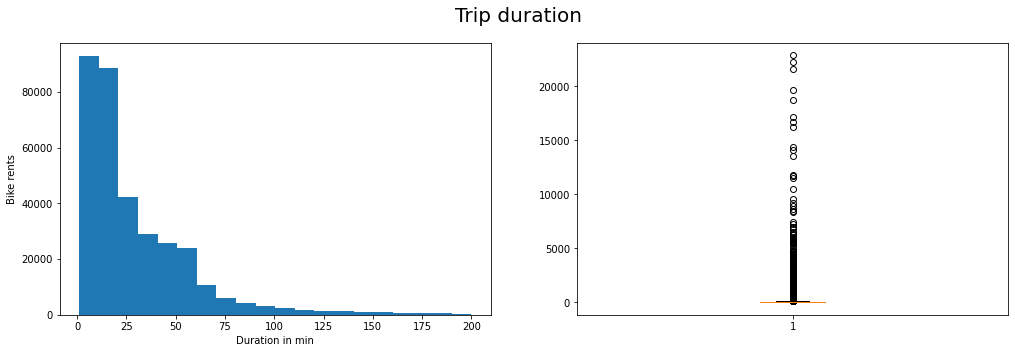

In [30]:
fig, ax = plt.subplots(1,2, figsize=(17,5))
duration2 = df2[df2['duration_in_min'] < 200]

ax[0].hist(duration2['duration_in_min'],bins=20)
ax[0].set_xlabel('Duration in min')
ax[0].set_ylabel('Bike rents')
ax[1].boxplot(duration)
plt.suptitle('Trip duration', fontsize=20)
plt.show()


# **ANALÝZA DOPYTU**

# **Vývoj dopytu po požičaní bicyklov v čase a príčiny výkyvu**









Vytvorím si prehľad výpožičiek po dňoch a mesiacoch a zobrazím si ich v grafe.


In [31]:
df_c = bikes['started_at'].dt.date
df_c = df_c.value_counts().sort_index()

df_m=bikes['started_at'].dt.strftime('%Y-%m')
df_m= df_m.value_counts().sort_index()

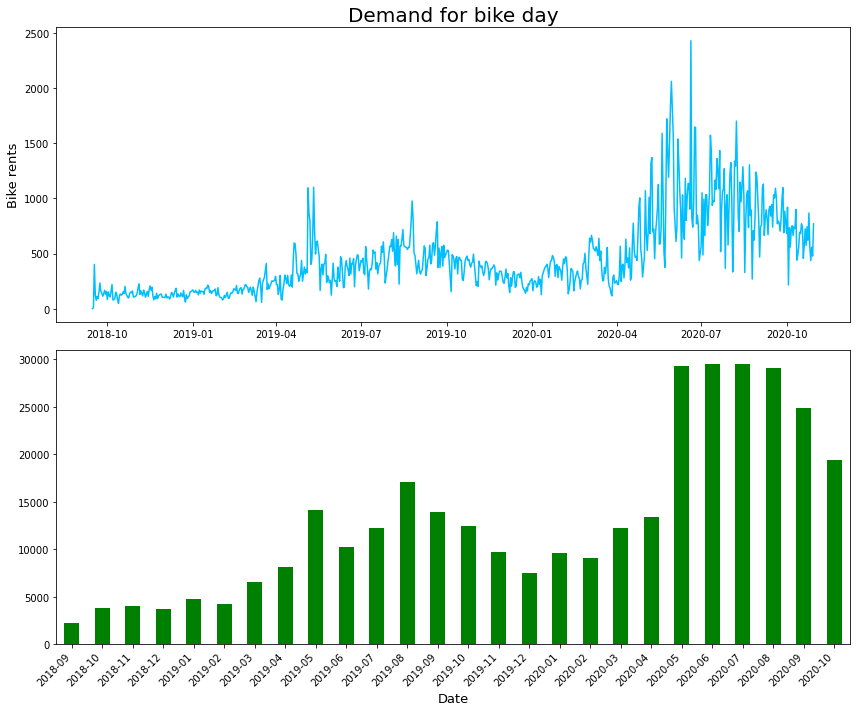

In [32]:
fig, ax = plt.subplots(2,1, figsize=(12,10))
df_c.plot(ax=ax[0], color = "DeepSkyBlue")
df_m.plot(kind='bar',ax=ax[1],  color='green')
ax[0].set_title('Demand for bike day', fontsize=20)
ax[1].set_xlabel('Date', fontsize=13)
ax[0].set_ylabel('Bike rents', fontsize=13)
ax[1].set_xticklabels(df_m.index, rotation=45, ha='right')
plt.tight_layout() 
plt.show()

Je vidieť, že dopyt po požičaní bicyklov od roku 2018 stúpa. Najväčší záujem býva v mesiacoch máj - august. Jedná sa o letné mesiace, preto predpokladám, že dôvodom môžu byť príjemnejšie klimatické podmienky a zvýšený záujem turistov v letnej sezóne. V zimných mesiacoch je zreteľný pokles záujmu o požičanie bicyklov.

V ďalšom kroku si analyzujem dopyt po bicykloch v priebehu dňa. 

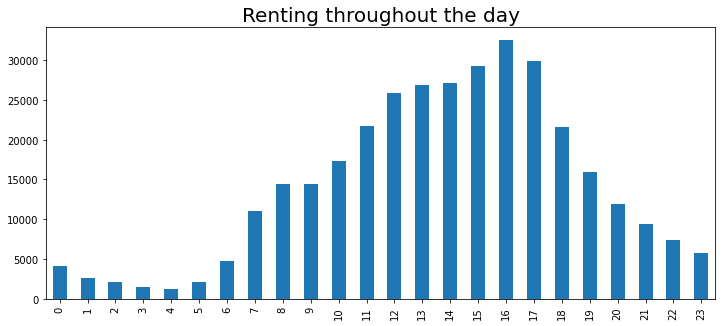

In [34]:
df = bikes['started_at'].dt.hour
df_h = df.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12,5))
df_h.plot(kind='bar')
plt.xticks(np.arange(0,24))
plt.title('Renting throughout the day',fontsize=20)
plt.show()

Ľudia najviac využívajú požičanie bicyklov behom dňa, hlavne medzi 12 a 17 hod a naopak po polnoci je záujem minimálny.

# **Vplyv počasia**

Najskôr si načítam dáta o počasí z databáze a zobrazím si informácie o datových typoch.

In [35]:
query = 'select * from edinburgh_weather'
weather = pd.read_sql(query, engeto_data_conn)
weather.head(5)


,time,temp,feels,wind,gust,rain,humidity,cloud,pressure,vis,date
0,00:00,11 °c,11 °c,9 km/h from S,19 km/h,0.0 mm,79%,13%,1020 mb,Excellent,2018-09-01
1,03:00,13 °c,12 °c,11 km/h from SSW,19 km/h,0.0 mm,76%,96%,1020 mb,Excellent,2018-09-01
2,06:00,14 °c,13 °c,11 km/h from SSW,19 km/h,0.0 mm,84%,100%,1020 mb,Excellent,2018-09-01
3,09:00,14 °c,13 °c,14 km/h from SSW,23 km/h,0.1 mm,88%,78%,1021 mb,Excellent,2018-09-01
4,12:00,16 °c,16 °c,15 km/h from SSW,22 km/h,0.0 mm,87%,87%,1021 mb,Excellent,2018-09-01


In [36]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6336 entries, 0 to 6335
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      6336 non-null   object
 1   temp      6336 non-null   object
 2   feels     6336 non-null   object
 3   wind      6336 non-null   object
 4   gust      6336 non-null   object
 5   rain      6336 non-null   object
 6   humidity  6336 non-null   object
 7   cloud     6336 non-null   object
 8   pressure  6336 non-null   object
 9   vis       6336 non-null   object
 10  date      6336 non-null   object
dtypes: object(11)
memory usage: 544.6+ KB


Vidím, že všetky údaje v tabuľke sú stringy, pre prácu s nimi potrebujem ale číslené hodnoty. Definovanou funkciou **convert** odstraním z dát, ktoré obsahujú medzery alebo znamienko %,  iné znaky než číselné a bodku. Využijem knihovnu re a upravené hodnoty konvertujem na datový typ float.
Ako index si zvolím dátum a čas.

In [37]:
def convert(value):
    if '%' in value or ' ' in value:
      c= re.sub(r'[^\d.]+','', value)
      return float(c)
    else:
      return value   
  

In [38]:
import re

w_df = weather.applymap(lambda x: convert(x))
w_df.set_index(['date','time'],inplace=True)
w_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6336 entries, ('2018-09-01', '00:00') to ('2020-10-31', '21:00')
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      6336 non-null   float64
 1   feels     6336 non-null   float64
 2   wind      6336 non-null   float64
 3   gust      6336 non-null   float64
 4   rain      6336 non-null   float64
 5   humidity  6336 non-null   float64
 6   cloud     6336 non-null   float64
 7   pressure  6336 non-null   float64
 8   vis       6336 non-null   object 
dtypes: float64(8), object(1)
memory usage: 510.7+ KB


V ďalšom bode si upravím tabuľku **bikes** tak, aby som v nej mala kumulované údaje o požičaných bicykloch za každé 3 hodiny každého dňa. Funkciou interval si pretvorím časové údaje do požadovanej podoby.

In [39]:
def interval(number):
  if number== 23:
    cislo=0
  elif number%3 ==2:
    cislo = (number//3+1)*3
  elif number%3 ==1:
   cislo = number//3*3
  else:
   cislo=number

  if cislo > 9:
    obj= str(cislo)+':00'
    return obj
  else:
    obj='0'+str(cislo)+':00'
    return obj

In [40]:
dfp= pd.DataFrame(bikes['started_at'].dt.strftime('%Y-%m-%d'))
dfp['time']=bikes['started_at'].dt.hour.apply(lambda x: interval(x))
dfp['count']=1
dfp.rename(columns={'started_at':'date'}, inplace=True)
dfp = dfp.groupby(['date','time']).count()
dfp.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5920 entries, ('2018-09-15', '09:00') to ('2020-10-30', '21:00')
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   5920 non-null   int64
dtypes: int64(1)
memory usage: 69.7+ KB


Pomocou join si spojím tabuľku o výpožičkach s tabuľkou o počasí.

In [41]:
tabulka=dfp.join(w_df, on=['date','time'] ,how='left')
tabulka

count  temp  feels  ...  cloud  pressure        vis
date       time                       ...                            
2018-09-15 09:00      3 10.00   8.00  ...  60.00   1019.00  Excellent
2018-09-16 12:00     10 14.00  11.00  ...  92.00   1008.00  Excellent
2018-09-17 09:00     66 13.00  12.00  ... 100.00   1009.00  Excellent
           12:00     94 16.00  16.00  ...  64.00   1007.00  Excellent
           15:00    123 16.00  16.00  ...  80.00   1003.00  Excellent
...                 ...   ...    ...  ...    ...       ...        ...
2020-10-30 09:00    118 10.00   7.00  ...  66.00   1006.00  Excellent
           12:00    168 11.00   8.00  ...  77.00   1009.00  Excellent
           15:00    182 10.00   8.00  ...  43.00   1012.00  Excellent
           18:00    149  8.00   6.00  ...  21.00   1014.00  Excellent
           21:00     95  7.00   6.00  ...  13.00   1015.00  Excellent

[5920 rows x 10 columns]

In [42]:
tabulka.describe(percentiles=[.25, .5, .75, .90, .99])

,count,temp,feels,wind,gust,rain,humidity,cloud,pressure
count,5920.00,5920.00,5920.00,5920.00,5920.00,5920.00,5920.00,5920.00,5920.00
mean,57.60,9.25,7.58,16.07,23.57,0.41,80.07,60.91,1011.23
std,70.50,4.70,5.37,9.06,12.96,1.31,10.50,33.87,13.51
min,1.00,0.00,0.00,0.00,0.00,0.00,38.00,0.00,960.00
25%,13.00,6.00,3.00,9.00,13.00,0.00,73.00,29.00,1002.00
50%,34.00,9.00,7.00,15.00,22.00,0.00,82.00,69.00,1013.00
75%,74.00,13.00,11.00,22.00,32.00,0.10,88.00,94.00,1021.00
90%,135.00,16.00,16.00,28.00,42.00,1.10,92.00,100.00,1028.00
99%,342.00,20.00,20.00,41.00,58.00,6.48,97.00,100.00,1038.00
max,702.00,27.00,29.00,54.00,79.00,23.40,99.00,100.00,1048.00


V ďalšom kroku si zobrazím bodové grafy vyjadrujúce vzťah medzi premennými a počtom výpožičiek.

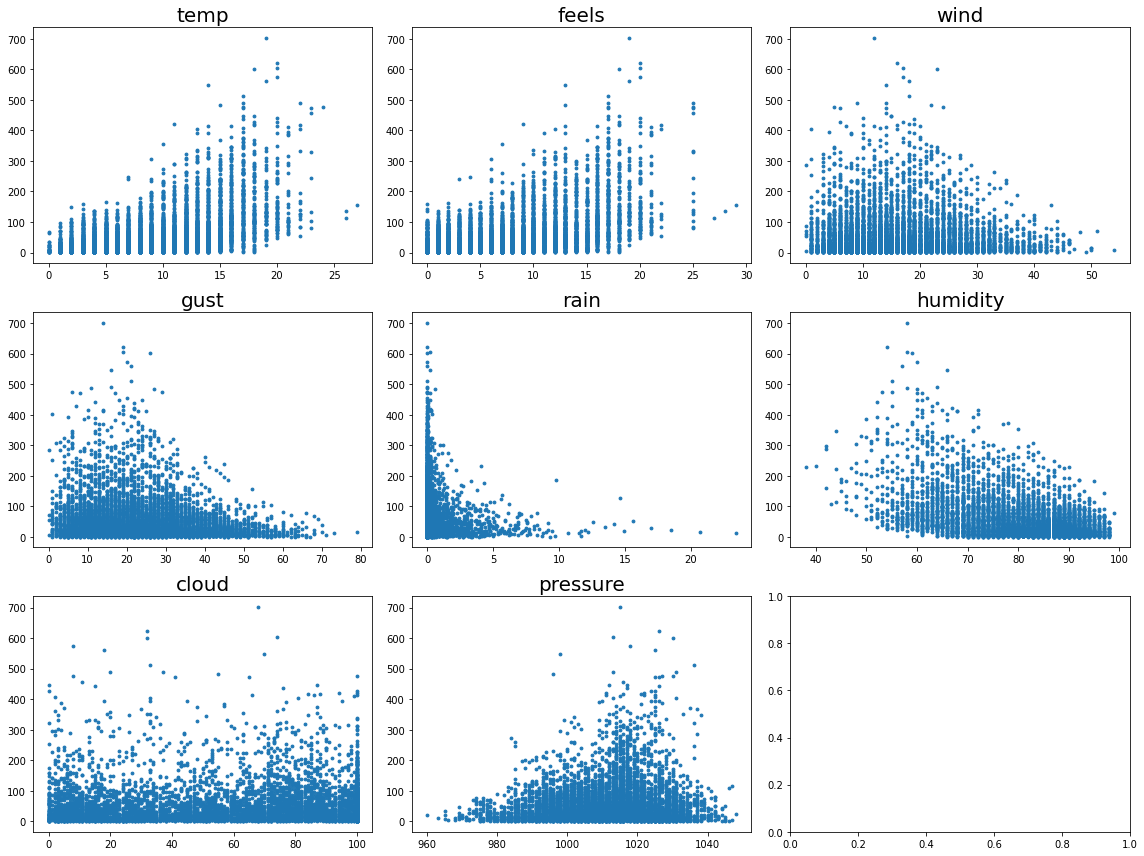

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,12))
axes = axes.flatten()

for i, variable in enumerate(['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud', 'pressure']):
  ax = axes[i]
  ax.scatter(tabulka[variable], tabulka['count'], label=variable, s=8)
  ax.set_title(variable, fontsize=20)

plt.tight_layout()
plt.show()


Zdá sa, že niektoré premenné (humidity, cloud, pressure) nemajú zásadný vplyv na dopyt po bicykloch. U ostatných premmených je možné pozorovať určitý trend: so vzrastajúcou teplotou majú ľudia tendenciu požičiavať si bicykle viac, so silnejším vetrom naopak menej. 
Zjavný trend je aj u množstva zrážok, s rastúcim množstvom dramaticky klesá záujem o bicykle.

Vplyv viditeľnosti si zobrazím v stĺpcovom grafe. Je z neho zrejmé, že drvivá väčšina výpožičiek sa odohrala za skvelej viditeľnosti.

In [44]:
vis = tabulka[['count', 'vis']].groupby('vis').sum()
vis

,count
vis,
Average,442
Excellent,315690
Good,12267
Poor,12587


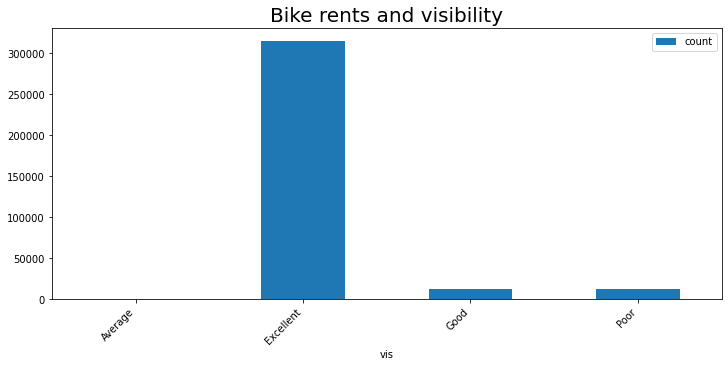

In [45]:
fig, ax = plt.subplots(figsize=(12,5))
vis.plot.bar(ax=ax)
ax.set_title('Bike rents and visibility', fontsize=20)
ax.set_xticklabels(vis.index, rotation=45, ha='right')
plt.show()

# **Požičiavajú si ľudia bicykle viac cez víkend?**

Na vyriešenie tejto úlohy si urobím výstup počtu výpožičiek v jednotlivých dňoch týždňa (0=pondelok).

In [46]:
day = bikes['started_at'].dt.weekday
day=day.value_counts().sort_index()
day

0    45090
1    45227
2    47168
3    49034
4    48669
5    54833
6    50965
Name: started_at, dtype: int64

Na zobrazenie využijem stĺpcový graf. Je z neho zrejmé, že si ľudia najmenej požičiavajú bicykle v pondelok, najviac v sobotu. Nedeľa je na tom s vyťaženosťou veľmi podobne ako štvrtok a piatok. 

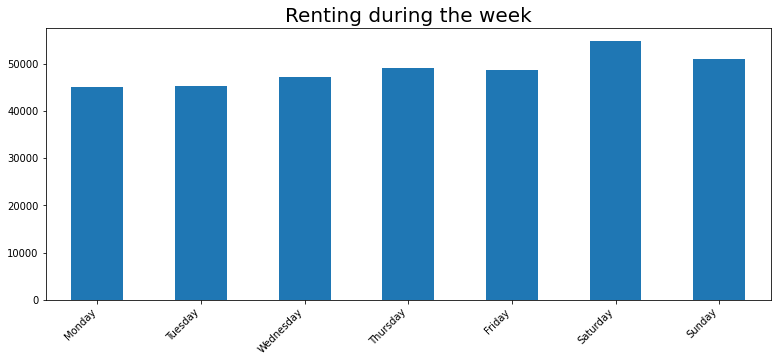

In [47]:
fig, ax = plt.subplots(figsize=(13,5))
day.plot(kind="bar")
ax.set_xticklabels(('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'), rotation=45, ha='right')
plt.title('Renting during the week', fontsize=20)
plt.show()